# Analysis of network made from the IMDB database

Made by Christian Fuglede and Emma Lind

study ids: s204206, s191159

# imports

To start of this notebook we load in the imports and graph that was made in load_data_1 and load_data_2 files

In [36]:
import pandas as pd
import networkx as nx
from imdb import IMDb
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from fa2_modified import ForceAtlas2
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import math
import powerlaw



# Load in graph

In [37]:
with open('Movie_network_with_synopses.gpickle', 'rb') as f:
    G_Movies = pickle.load(f)

print("The number of nodes in the network is: ", G_Movies.number_of_nodes())
print("The number of edges in the network is: ", G_Movies.number_of_edges())

The number of nodes in the network is:  9596
The number of edges in the network is:  1183130


In [38]:
#largest component
largest_component = max(nx.connected_components(G_Movies), key=len)
G_Movies = G_Movies.subgraph(largest_component)

print("The number of nodes in the network is: ", G_Movies.number_of_nodes())
print("The number of edges in the network is: ", G_Movies.number_of_edges())

The number of nodes in the network is:  9586
The number of edges in the network is:  1183121


# Degree distribution

We have started out with trying to analyse our degree distribution of the network, to do this we first ploted the degree distribution to see if it was anything we had seen before.

In [39]:
# Create dictionaries to store the count of movies each actor has appeared in and actor names
actor_movie_counts = Counter()
actor_names = {}

# Populate the actor_movie_counts and actor_names dictionaries
for _, movie_data in G_Movies.nodes(data=True):
    actors = movie_data.get('actors', [])
    for actor_id, actor_name in actors:
        actor_movie_counts[actor_id] += 1
        actor_names[actor_id] = actor_name

# Sort actors by the number of movies they have appeared in, in descending order
sorted_actors = sorted(actor_movie_counts.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 actors
print("Top 10 actors who have connected the most nodes:")
for actor_id, count in sorted_actors[:10]:
    actor_name = actor_names[actor_id]
    print(f"Actor: {actor_name}, Movies: {count}")

Top 10 actors who have connected the most nodes:
Actor: Spencer Kayden, Movies: 278
Actor: Samantha Kelly, Movies: 164
Actor: Frank Welker, Movies: 127
Actor: Bess Flowers, Movies: 113
Actor: Samuel L. Jackson, Movies: 94
Actor: Greg Bronson, Movies: 90
Actor: Mark Falvo, Movies: 87
Actor: Sam Harris, Movies: 84
Actor: Jimmy Star, Movies: 83
Actor: Arnold Montey, Movies: 75


In [41]:
# Initialize variables to store the oldest and newest films
oldest_film = None
newest_film = None
oldest_year = float('inf')
newest_year = float('-inf')

# Iterate through the nodes in the graph
for node, data in G_Movies.nodes(data=True):
    year = data.get('year')
    if year is not None:
        if year < oldest_year:
            oldest_year = year
            oldest_film = data.get('title', 'Unknown')
        if year > newest_year:
            newest_year = year
            newest_film = data.get('title', 'Unknown')

# Print the results
print(f"The oldest film is '{oldest_film}' from the year {oldest_year}.")
print(f"The newest film is '{newest_film}' from the year {newest_year}.")

The oldest film is 'The Great Train Robbery' from the year 1903.
The newest film is 'Black Panther' from the year 2018.


In [42]:
# Get the degree of each node in the graph
movie_degrees = dict(G_Movies.degree())

# Sort the movies by degree in descending order
sorted_movies_by_degree = sorted(movie_degrees.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 movies with the most degrees
top_10_movies_by_degree = sorted_movies_by_degree[:10]

# Print the top 10 movies with the most degrees
print("Top 10 movies with the most degrees:")
for movie_id, degree in top_10_movies_by_degree:
    movie_title = G_Movies.nodes[movie_id].get('title', 'Unknown')
    print(f"Movie: {movie_title}, Degree: {degree}")

Top 10 movies with the most degrees:
Movie: Magnolia, Degree: 1307
Movie: The Dark Knight Rises, Degree: 1262
Movie: Spider-Man 3, Degree: 1252
Movie: The Player, Degree: 1248
Movie: Spider-Man 2, Degree: 1238
Movie: Catch Me If You Can, Degree: 1180
Movie: Spider-Man, Degree: 1162
Movie: Pearl Harbor, Degree: 1161
Movie: Independence Day, Degree: 1158
Movie: Enemy of the State, Degree: 1152


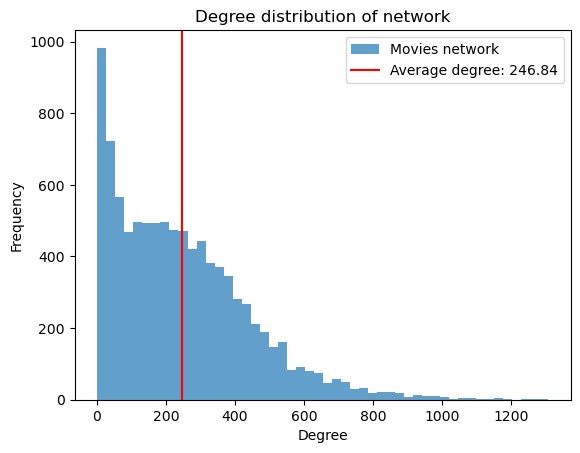

In [43]:
degree_sequence = [degree for node, degree in nx.degree(G_Movies)]

plt.hist(degree_sequence, bins=50, alpha=0.7, label="Movies network")
#show average degree on legend
plt.axvline(x=sum(degree_sequence)/len(degree_sequence), color='red', label="Average degree: {:.2f}".format(sum(degree_sequence)/len(degree_sequence)))
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree distribution of network")
plt.legend()
plt.show()

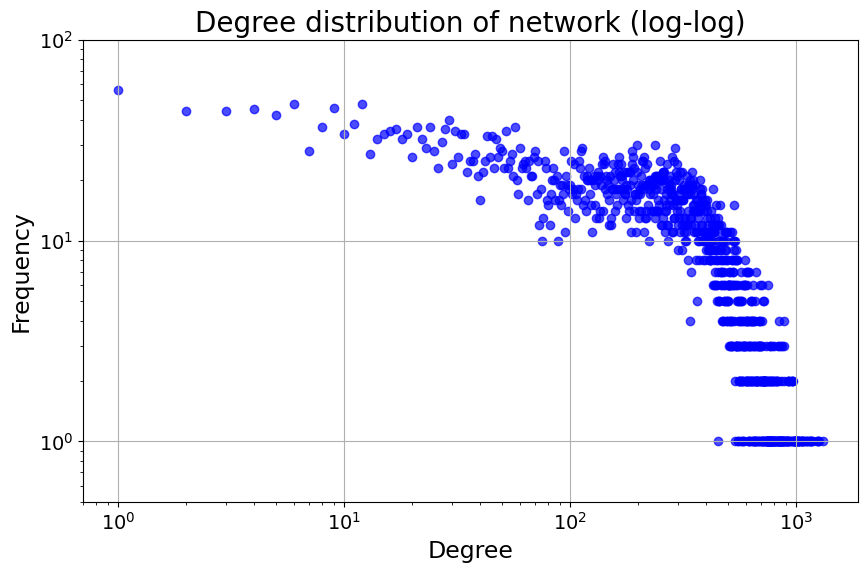

In [44]:
# Convert degree_counts to two lists: one for degrees and one for counts
degree_counts = Counter(degree_sequence)
degrees, counts = zip(*degree_counts.items())

plt.figure(figsize=(10, 6))
plt.scatter(degrees, counts, alpha=0.7, label="Movies network", color='blue')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.5, 1e2)
plt.xlabel("Degree", fontsize=17)
plt.ylabel("Frequency", fontsize=17)
plt.title("Degree distribution of network (log-log)", fontsize=20)
plt.xticks(fontsize=14)
plt.grid(True)
plt.yticks(fontsize=14)
plt.show()


The network does not seem to follow a power law whan plotting the degree distribution in a log-log format, This indicates that our network is not a scale-free network.

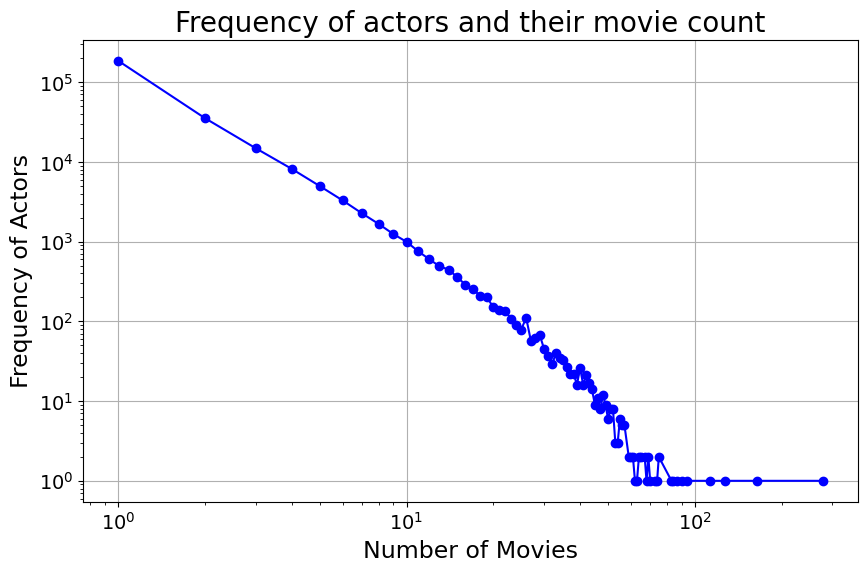

In [48]:
# Get the frequency of actors in movies
movies_per_actor_limited = [count for actor_id, count in sorted_actors]

# Count the occurrences of each number of movies
movies_per_actor_counts = Counter(movies_per_actor_limited)

# Sort the counts by the number of movies
sorted_movies_per_actor_counts = sorted(movies_per_actor_counts.items(), key=lambda x: x[0])

# Separate the data into two lists for plotting
movies, counts = zip(*sorted_movies_per_actor_counts)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(movies, counts, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Movies', fontsize=17)
plt.ylabel('Frequency of Actors', fontsize=17)
plt.yscale('log')
plt.xscale('log')
plt.title('Frequency of actors and their movie count', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

Now lets analyse why our network do not look to be scale free

In [15]:
# Total number of movies
total_movies = G_Movies.number_of_nodes()

# Calculate the cumulative number of movies covered by actors
cumulative_movies = 0
num_actors = 0

# Find the number of actors required to cover 80% of the movies
movies_covered = set()
for actor_id, count in sorted_actors:
    cum_movies_pre = cumulative_movies
    if len(movies_covered) >= 0.8 * total_movies:
        break
    for movie, data in G_Movies.nodes(data=True):
        if actor_id in [actor[0] for actor in data.get('actors', [])]:
            movies_covered.add(movie)
    cumulative_movies = len(movies_covered)
    if cumulative_movies > cum_movies_pre:
        num_actors += 1
#number of actors
all_actors = len(actor_movie_counts)
#minus actors that are only in one movie
all_actors = all_actors - len([actor for actor, count in actor_movie_counts.items() if count == 1])

# Calculate the percentage of actors
percent_actors = (num_actors / all_actors) * 100

print(f"Percentage of actors that can cover 80% of the movies: {percent_actors:.2f}%")

Percentage of actors that can cover 80% of the movies: 1.41%


It is generally considered that a power law follows the 80 20 rule. In our case that would mean that 80% of the movies could be connected by 20% of the actors. We see that in our network that 1.41% of the actors can be used to connect 80% of the movies.

This shows that we are likely not dealing with a scale free network, we then move on to see what the degree exponent is. if the exponent is higher than 3 we are likely seing a random network and if the exponent is between 2 and 3, we are more likely in scale free network. 

In [ ]:
def calculate_degree_exponent(G):
    # Step 1: Get the degree sequence
    degrees = [deg for _, deg in G.degree()]
    
    # Step 2: Fit a power-law distribution using the `powerlaw` package
    fit = powerlaw.Fit(degrees, discrete=True)
    
    # Step 3: Extract the exponent (gamma)
    gamma = fit.power_law.alpha  # Power-law exponent
    kmin = fit.power_law.xmin    # Minimum value for power-law behavior
    
    return gamma, kmin

gamma, kmin = calculate_degree_exponent(G_Movies)
print(f"Degree Exponent: {gamma}")
print(f"Minimum degree for Power-Law Behavior (kmin): {kmin}")

Calculating best minimal value for power law fit
Degree Exponent: 4.820820998495873
Minimum degree for Power-Law Behavior (kmin): 457.0


Since the degree exponent is cuite higher than 3 we are likely in a random network instead of a scale-free network. the kmin, tells us that we have to cut off all nodes with degree less than 457 in order to obtain a scale free network.

Lastly we tried to see if our network might resemble a small world network. In the code below we have created a random network with the same amount of nodes and links as our movie network. Then we find the average path length and clustering coefficient of the two networks and analyse. This part of the code can be skipped to run since it takes a lot of time to calculate and the results are already displayed

In [34]:
def test_small_world(network):
    # Calculate clustering coefficient and average path length for the actual network
    clustering_actual = nx.average_clustering(network)
    path_length_actual = nx.average_shortest_path_length(network)
   
    # Generate a random network with the same number of nodes and edges
    n = network.number_of_nodes()
    m = network.number_of_edges()
    random_network = nx.gnm_random_graph(n, m)

    # Calculate clustering coefficient and average path length for the random network
    clustering_random = nx.average_clustering(random_network)
    path_length_random = nx.average_shortest_path_length(random_network)

    # Compare results
    result = {
        "Actual Clustering Coefficient": clustering_actual,
        "Random Clustering Coefficient": clustering_random,
        "Actual Average Path Length": path_length_actual,
        "Random Average Path Length": path_length_random,
    }
    return result

small_world_results = test_small_world(G_Movies)
print(small_world_results)

{'Actual Clustering Coefficient': 0.2550670909436903, 'Random Clustering Coefficient': 0.025772498802316225, 'Actual Average Path Length': 2.3143460930950317, 'Random Average Path Length': 1.9759284236999686}


We notice that the clustering coefficient for our movie network is 10 times higher than that of the random network. The average shortest path length is small for both the movie and random network indicating that the networks are very well connected. Both of these indicates that we have a small-world network.

# Communities

In the following we have made 3 communities, a rating, decade and genre community to analyse what most defines the inteconnections between the nodes using the modulairty. we have printed each community to get an idea of how movies are distributed.

In [49]:
# Create a dictionary to store the communities
rating_communities = {}

# Define the bins
bins = [(i, i+1) for i in range(10)]  # (0-0.5, 0.5-1, 1-1.5, ..., 9.5-10)

# Initialize the communities
for bin_range in bins:
    rating_communities[bin_range] = []

# Populate the communities based on the movie ratings
for node, data in G_Movies.nodes(data=True):
    rating = data.get('rating')
    if rating is not None:
        for bin_range in bins:
            if bin_range[0] <= rating < bin_range[1]:
                rating_communities[bin_range].append(node)
                break

# Print the communities
for bin_range, movies in rating_communities.items():
    print(f"Rating range {bin_range}: {len(movies)} movies")

Rating range (0, 1): 0 movies
Rating range (1, 2): 7 movies
Rating range (2, 3): 28 movies
Rating range (3, 4): 108 movies
Rating range (4, 5): 439 movies
Rating range (5, 6): 1569 movies
Rating range (6, 7): 3483 movies
Rating range (7, 8): 3288 movies
Rating range (8, 9): 644 movies
Rating range (9, 10): 20 movies


In [50]:
#make communities in terms of decades
# Create a dictionary to store the communities
decade_communities = {}

# Define the bins
bins = [(i, i+10) for i in range(1900, 2020, 10)]  # (1900-1910, ..., 2010-2020)

# Initialize the communities
for bin_range in bins:
    decade_communities[bin_range] = []

# Populate the communities based on the movie ratings
for node, data in G_Movies.nodes(data=True):
    year = data.get('year')
    if year is not None:
        for bin_range in bins:
            if bin_range[0] <= year < bin_range[1]:
                decade_communities[bin_range].append(node)

# Print the communities
for bin_range, movies in decade_communities.items():
    print(f"Decade range {bin_range}: {len(movies)} movies")

Decade range (1900, 1910): 1 movies
Decade range (1910, 1920): 7 movies
Decade range (1920, 1930): 35 movies
Decade range (1930, 1940): 135 movies
Decade range (1940, 1950): 196 movies
Decade range (1950, 1960): 277 movies
Decade range (1960, 1970): 398 movies
Decade range (1970, 1980): 497 movies
Decade range (1980, 1990): 1181 movies
Decade range (1990, 2000): 2186 movies
Decade range (2000, 2010): 2773 movies
Decade range (2010, 2020): 1900 movies


In [51]:
# Create a dictionary to store the communities
genre_communities = {}

# Populate the communities based on the first genre of each movie
for node, data in G_Movies.nodes(data=True):
    genres = data.get('genre')
    if genres:
        first_genre = genres[0]
        if first_genre not in genre_communities:
            genre_communities[first_genre] = []
        genre_communities[first_genre].append(node)

#if a community has less than 3 movies, append its movies to the movies second genre
for genre, movies in list(genre_communities.items()):
    if len(movies) < 3:
        # Get the second genre of each movie
        for movie in movies:
            second_genre = G_Movies.nodes[movie].get('genre')[1] if len(G_Movies.nodes[movie].get('genre')) > 1 else None
            if second_genre:
                if second_genre not in genre_communities:
                    genre_communities[second_genre] = []
                genre_communities[second_genre].append(movie)
        del genre_communities[genre]


# Print the communities
for genre, movies in genre_communities.items():
    print(f"Genre: {genre}, Number of movies: {len(movies)}")

#print the amount of movies across the all communitites
total_movies = 0
for genre, movies in genre_communities.items():
    total_movies += len(movies)
print(f"Total number of movies across all communities: {total_movies}")

Genre: Comedy, Number of movies: 2830
Genre: Action, Number of movies: 1874
Genre: Adventure, Number of movies: 589
Genre: Animation, Number of movies: 581
Genre: Biography, Number of movies: 433
Genre: Drama, Number of movies: 1681
Genre: Crime, Number of movies: 638
Genre: Mystery, Number of movies: 25
Genre: Documentary, Number of movies: 397
Genre: Horror, Number of movies: 383
Genre: Fantasy, Number of movies: 51
Genre: Family, Number of movies: 8
Genre: Short, Number of movies: 32
Genre: Romance, Number of movies: 9
Genre: Film-Noir, Number of movies: 7
Genre: Thriller, Number of movies: 14
Genre: Sci-Fi, Number of movies: 17
Genre: Western, Number of movies: 6
Genre: Musical, Number of movies: 10
Total number of movies across all communities: 9585


we now want to calculate the modularity of each community to see how well the distributions are using the attributes from the nodes.

In [52]:
def calculate_modularity(G, communities):
    # Total number of edges in the graph
    L = G.number_of_edges()
    
    # Initialize modularity
    modularity = 0
    
    # Group nodes by community
    community_groups = {}
    for node, community in communities.items():
        if community not in community_groups:
            community_groups[community] = []
        community_groups[community].append(node)
    
    # Iterate over each community
    for community_nodes in community_groups.values():
        # Calculate L_c (number of edges within the community)
        L_c = 0
        for node1 in community_nodes:
            for node2 in community_nodes:
                if G.has_edge(node1, node2):
                    L_c += 1
        L_c /= 2  # Each edge is counted twice
        
        # Calculate k_c (sum of degrees of nodes in the community)
        k_c = sum(G.degree(node) for node in community_nodes)
        
        # Calculate modularity contribution for the current community
        modularity += (L_c / L) - (k_c / (2 * L)) ** 2
    
    return modularity

In [53]:
# Calculate modularity in the decade communities
modularity_rating = calculate_modularity(G_Movies, {node: rating for rating, nodes in rating_communities.items() for node in nodes})
print(f"Modularity of ratings communities: {modularity_rating}")

# Calculate modularity in the decade communities
modularity_decade = calculate_modularity(G_Movies, {node: decade for decade, nodes in decade_communities.items() for node in nodes})
print(f"Modularity of decade communities: {modularity_decade}")

# Calculate modularity in the genre communities
modularity_genre = calculate_modularity(G_Movies, {node: genre for genre, nodes in genre_communities.items() for node in nodes})
print(f"Modularity of genre communities: {modularity_genre}")

# Find the optimal community structure based on the graph structure
optimal_communities = nx.algorithms.community.greedy_modularity_communities(G_Movies)

#calculate modulairty of the optimal community
modularity_optimal = calculate_modularity(G_Movies, {node: i for i, nodes in enumerate(optimal_communities) for node in nodes})
print(f"Modularity of optimal communities: {modularity_optimal}")

Modularity of ratings communities: 0.026948087414263057
Modularity of decade communities: 0.14575351271955717
Modularity of genre communities: 0.0667273230372959
Modularity of optimal communities: 0.225929026537459


We wanted to check the modularities with a greedy modularity distribution, to get an idea of how well communities can be made. We see here that the ratings of the movies is not a good way to make communities, indicating that the actors is not at fault for creating bad movies. It is somewhat obvius making communities based on the decade the movie was made in shows a good distribution, this is because actors are simply because fame can be short-lived and because actors do not live forever. Lastly we notice that actors are not generally defind by their genre, this comes from that many movies have more than one genre and it is hard to make these seperations in which genre to choose, but it also shows actors are not genre cast.

# TF-IDF

We now want to look some text for some of these movies. We have downloaded the synopsis and the summary of the movie if the synopsis was not written. We have then added the text to the movie as an attribute. 

In [54]:
# IDF function 
# IDF(t,D)  = log( (Total number of documents, D) / (Number of documents with term t in them) )
def idf(term, term_freqs):
    # Count in how many term_freqs the term appears in
    
    num_appearances = 0
    
    for genre, term_freq in term_freqs.items():
        if term in term_freq:
            num_appearances += 1

    return math.log( len(term_freqs) / num_appearances )

# TF function
# TF(t,d) = (Number of times term t appears in a document) / (Total number of terms in the document)
def tf(term, term_freq):
    total_terms = sum(term_freq.values())
    
    return term_freq[term] / total_terms

# TF-IDF function
def tf_idf(term, term_freq, term_freqs):
    return tf(term, term_freq) * idf(term, term_freqs)

Constructing text files based on genre

In [55]:
# Create a dictionary to store the synopses for each community
community_synopses = {}

# Iterate through the genre communities and concatenate synopses
for genre, movies in genre_communities.items():
    synopses = []
    for movie in movies:
        synopsis = G_Movies.nodes[movie].get('synopsis')
        if synopsis:
            synopses.append(synopsis)
    community_synopses[genre] = ' '.join(synopses)

# Print the synopses for each community
for genre, synopsis in community_synopses.items():
    print(f"Genre: {genre}, Synopsis: {synopsis[:500]}...")  # Print only the first 500 characters for brevity

Genre: Comedy, Synopsis: The film begins 4 years after the events of the first one, with George Banks (Steve Martin) telling the audience he is ready for the empty nest he'll shortly receive with all of his children grown up. Shortly thereafter, Annie (Kimberly Williams) tells the family that she's pregnant, and George begins to mildly panic, insisting he is too young to be a grandfather. He has his assistant make a list of people who are older than him, dyes his hair brown and has passionate sex with Nina, and decides ...
Genre: Action, Synopsis: A former fireman takes on a group of terrorists holding the Vice President and others hostage during the seventh game of the NHL Stanley Cup finals. In 1986, MI6 agents James Bond (Pierce Brosnan) and Alec Trevelyan (Sean Bean) infiltrate a Soviet chemical weapons facility in Arkhangelsk. While Trevelyan is seemingly caught by Colonel Arkady Grigorovich Ourumov (Gottfried John)(a Hero of the Soviet Union, Commander of Russia's Space Division.

In [56]:
# Calculate term frequencies for each community
term_freqs = {}
for genre, synopsis in community_synopses.items():
    tokens = synopsis.split()
    term_freqs[genre] = Counter(tokens)

# Calculate TF-IDF for each term in each community
tf_idfs = {}
for genre, term_freq in term_freqs.items():
    tf_idfs[genre] = {term: tf_idf(term, term_freq, term_freqs) for term in term_freq}

In [57]:
def load_happiness_data(filename='Data_Set_S1.txt'):
    happiness_dict = {}
    with open(filename, 'r') as file:
        # Skip the first two descriptive lines, the space and the header line
        next(file)
        next(file)
        next(file)
        next(file)
        
        for line in file:
            columns = line.strip().split('\t')
            word = columns[0]  # Convert word to lowercase
            happiness_average = float(columns[2])  # Convert happiness_average to float
            
            # Add word and happiness_average to dictionary
            happiness_dict[word] = happiness_average
            
    return happiness_dict

# Example usage:
happiness_data = load_happiness_data()

# Sentiment calculation function
def sentiment(token_text):
    h_avg = 0
    total_count = 0
    
    # Calculate weighted average of happiness scores
    for token, count in token_text.items():
        h_score = happiness_data.get(token)
        if h_score is not None:
            h_avg += h_score * count
            total_count += count

    # Avoid division by zero if no matching words are found
    h_avg = h_avg / total_count if total_count > 0 else 0
    return h_avg


After we have used TF-IDF to find the most defining words for each genre, we calculated the sentiment score for each of the genres.

In [58]:
# Calculate sentiment scores for each genre
genre_sentiments = {}
for genre, synopsis in community_synopses.items():
    tokens = synopsis.split()
    token_counts = Counter(tokens)
    genre_sentiments[genre] = sentiment(token_counts)

# Print the sentiment scores for each genre
for genre, sentiment_score in genre_sentiments.items():
    print(f"Genre: {genre}, Sentiment Score: {sentiment_score}")

#print biggest differnce in sentiments
max_sentiment = max(genre_sentiments.values())
min_sentiment = min(genre_sentiments.values())
max_genre = max(genre_sentiments, key=genre_sentiments.get)
min_genre = min(genre_sentiments, key=genre_sentiments.get)

print(f"The genre with the highest sentiment score is {max_genre} with a score of {max_sentiment}")
print(f"The genre with the lowest sentiment score is {min_genre} with a score of {min_sentiment}")

Genre: Comedy, Sentiment Score: 5.357877895223241
Genre: Action, Sentiment Score: 5.242169244713042
Genre: Adventure, Sentiment Score: 5.307792038796552
Genre: Animation, Sentiment Score: 5.314469423854739
Genre: Biography, Sentiment Score: 5.3285574818651815
Genre: Drama, Sentiment Score: 5.332984784868836
Genre: Crime, Sentiment Score: 5.269282328963353
Genre: Mystery, Sentiment Score: 5.284011379800854
Genre: Documentary, Sentiment Score: 5.348504755145487
Genre: Horror, Sentiment Score: 5.273242993782718
Genre: Fantasy, Sentiment Score: 5.290345969161023
Genre: Family, Sentiment Score: 5.404383401519581
Genre: Short, Sentiment Score: 5.3023019431987946
Genre: Romance, Sentiment Score: 5.425124407582931
Genre: Film-Noir, Sentiment Score: 5.29752419765664
Genre: Thriller, Sentiment Score: 5.2716218721037995
Genre: Sci-Fi, Sentiment Score: 5.275725209669454
Genre: Western, Sentiment Score: 5.302312729177579
Genre: Musical, Sentiment Score: 5.437736486486484
The genre with the highest 

As we see here the difference is not that big in sentiment scores. When the try to see what words define the genres the most below in the wordcloud. We made sure to filter the wordcloud with the words that are in the Data_Set_S1. This help filter out names in the text that we find irrelevant. Especially names like James Bond come up a lot when you do not filter since it is a big franchise.

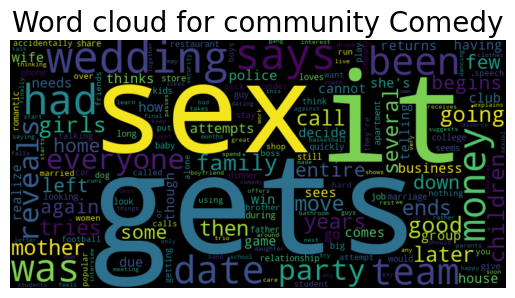

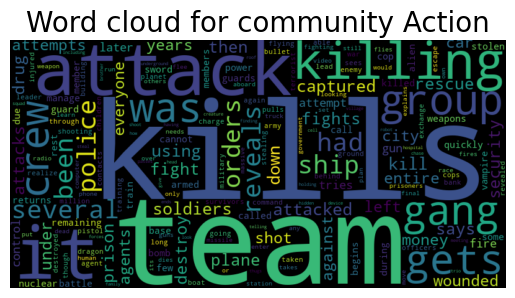

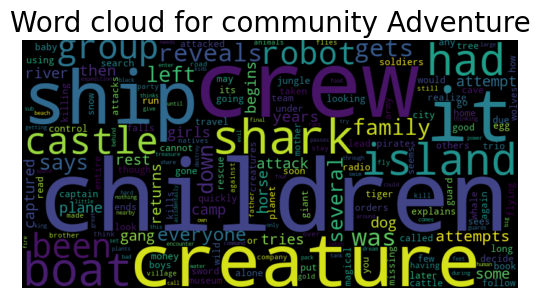

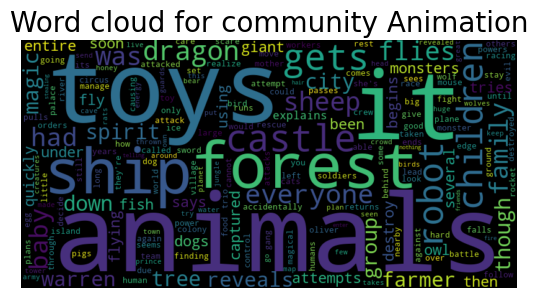

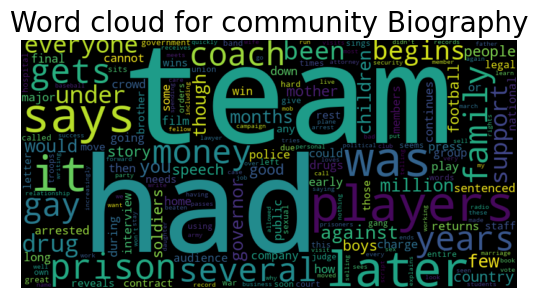

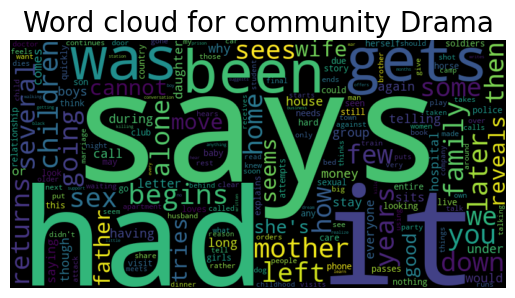

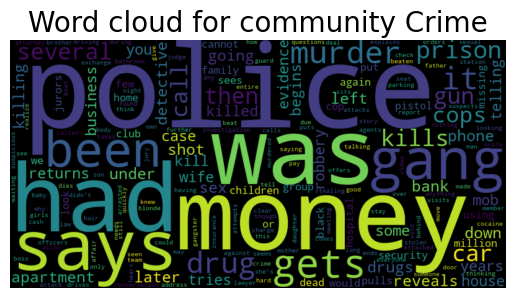

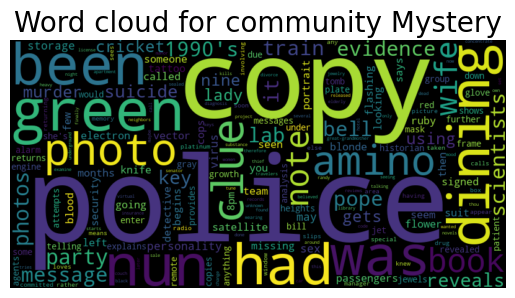

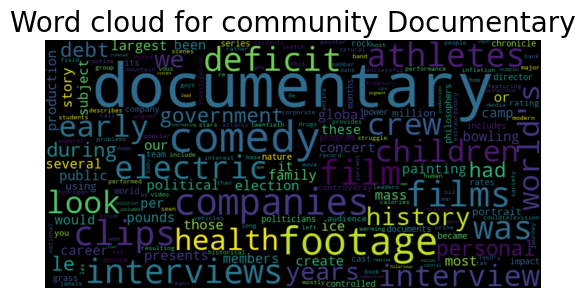

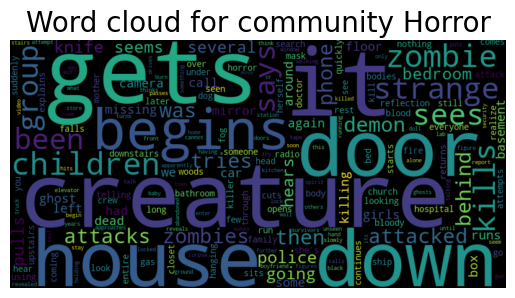

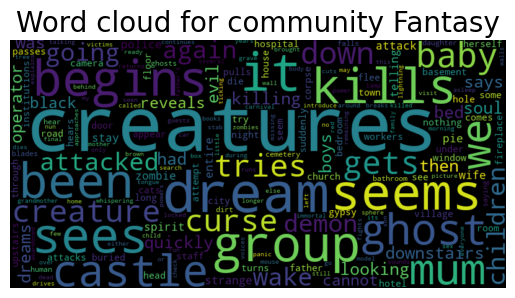

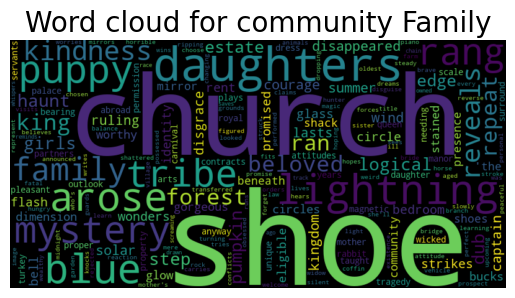

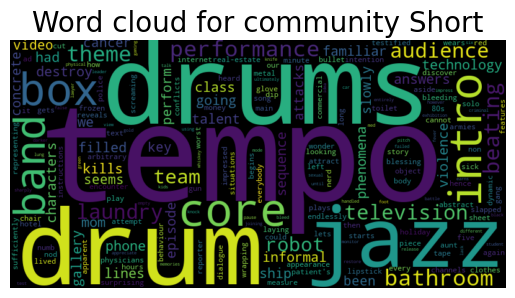

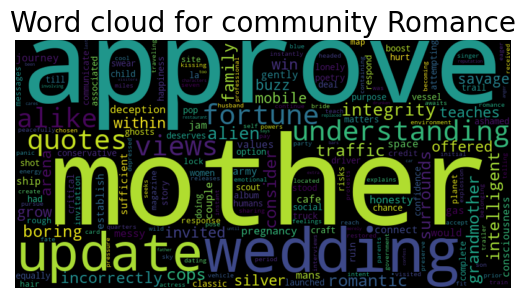

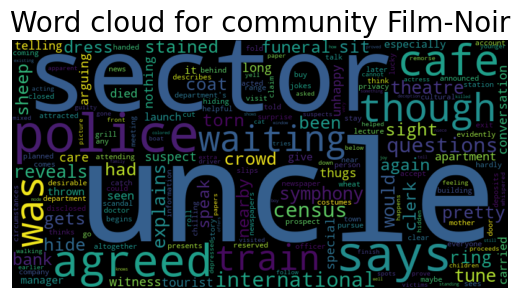

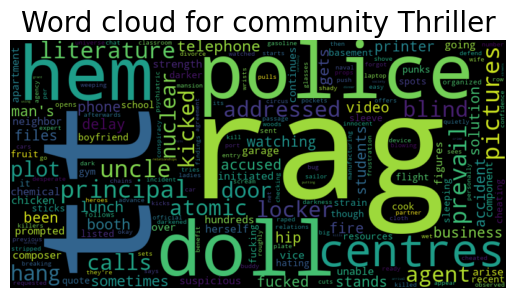

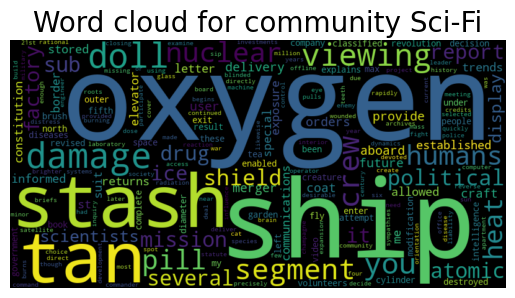

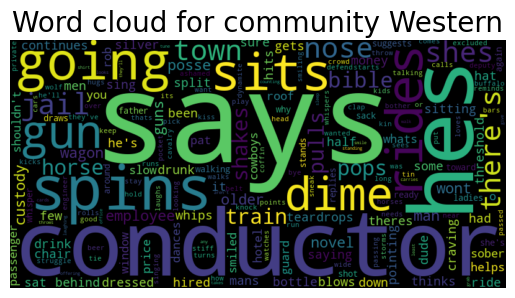

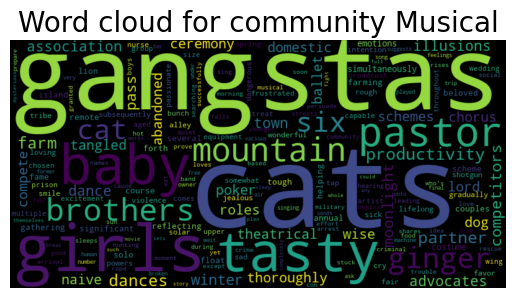

In [59]:
# Filter the tf_idf_dict to include only words that have a sentiment score
filtered_tf_idfs = {}
for genre, tf_idf_dict in tf_idfs.items():
    filtered_tf_idfs[genre] = {word: score for word, score in tf_idf_dict.items() if word in happiness_data}

# Generate and plot the word cloud for each genre
for genre, filtered_tf_idf_dict in filtered_tf_idfs.items():
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(filtered_tf_idf_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word cloud for community {genre}", fontsize=20)
    plt.show()

As we see in the wordcloud it is the expected result that the words are something that you could associate with the genre.

# Sentiments

To further see if we could use TF-IDF to define genres. we made a variable so you can change how big a percent of the highest scoring words in the TF-IDF, should be used in the calculation of the sentiment score.

In [60]:
# Define the percentage of top words to include (e.g., 50% for top half)
top_percentage = 10

# Calculate sentiment scores for each genre using the specified percentage of top words in the filtered_tf_idfs
top_genre_sentiments = {}
for genre, tf_idf_dict in filtered_tf_idfs.items():
    # Sort the words by their TF-IDF scores in descending order
    sorted_words = sorted(tf_idf_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Calculate the number of top words to select based on the specified percentage
    num_top_words = int(len(sorted_words) * (top_percentage / 100))
    
    # Select the top words based on the specified percentage
    top_words = dict(sorted_words[:num_top_words])
    
    # Calculate the sentiment score using the selected words
    token_counts = Counter(top_words)
    top_genre_sentiments[genre] = sentiment(token_counts)

# Print the sentiment scores for each genre using the specified percentage of top words
for genre, sentiment_score in top_genre_sentiments.items():
    print(f"Genre: {genre}, Sentiment Score (Top {top_percentage}% defining words): {sentiment_score}")

Genre: Comedy, Sentiment Score (Top 10% defining words): 5.706093986304603
Genre: Action, Sentiment Score (Top 10% defining words): 5.109659410407242
Genre: Adventure, Sentiment Score (Top 10% defining words): 5.4842313023271325
Genre: Animation, Sentiment Score (Top 10% defining words): 5.552765394290546
Genre: Biography, Sentiment Score (Top 10% defining words): 5.497602846864578
Genre: Drama, Sentiment Score (Top 10% defining words): 5.5167169067900685
Genre: Crime, Sentiment Score (Top 10% defining words): 5.138897819554725
Genre: Mystery, Sentiment Score (Top 10% defining words): 5.477470640067496
Genre: Documentary, Sentiment Score (Top 10% defining words): 5.663232818905613
Genre: Horror, Sentiment Score (Top 10% defining words): 5.217502394106053
Genre: Fantasy, Sentiment Score (Top 10% defining words): 5.2920746132646626
Genre: Family, Sentiment Score (Top 10% defining words): 5.99451736556046
Genre: Short, Sentiment Score (Top 10% defining words): 5.457138353513545
Genre: Rom

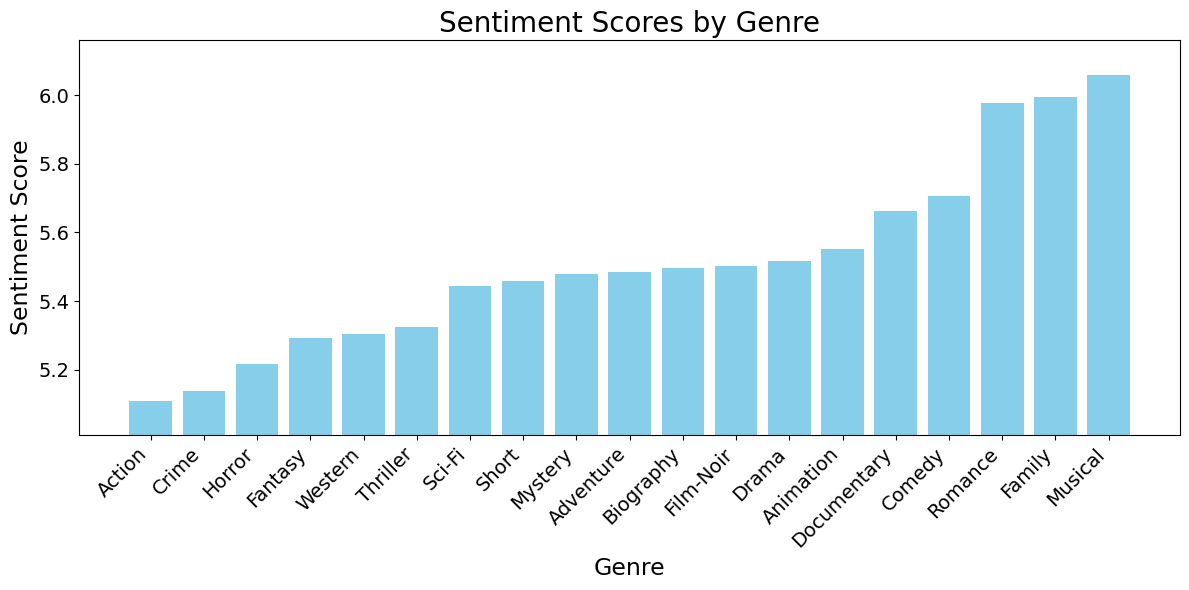

In [61]:
# Extract genres and their corresponding sentiment scores
sorted_sentiments = sorted(top_genre_sentiments.items(), key=lambda x: x[1])
genres = [genre for genre, _ in sorted_sentiments]
sentiment_scores_sorted = [score for _, score in sorted_sentiments]

# Plot the sentiment scores
plt.figure(figsize=(12, 6))
plt.bar(genres, sentiment_scores_sorted, color='skyblue')
plt.xlabel('Genre', fontsize=17)
plt.ylabel('Sentiment Score', fontsize=17)
plt.title('Sentiment Scores by Genre', fontsize=20)
plt.ylim(min(sentiment_scores_sorted) - 0.1, max(sentiment_scores_sorted) + 0.1)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

It is shown here that by shrinking down the words used we get a clearer picture of the difference in the words used in the synopses of the movies. The results are also what we expected, with having action, crime and horror at the bottom, which have words liek "kills", "murder" and "zombie" which have low sentiment values. And at the top we have gernes like musical, family and romance with words like "church", "wedding" and "dances" which have high sentiment values.

We then wanted to look at if big horrific historic events had an impact on the movies we see. To do this we look at movies from before and after 2001 which is the year 9/11 happened. 

In [62]:
# Create subgraphs for movies before and after 2001
G_Movies_before_2001 = G_Movies.subgraph([node for node, data in G_Movies.nodes(data=True) if data.get('year') and data['year'] <= 2001])
G_Movies_after_2001 = G_Movies.subgraph([node for node, data in G_Movies.nodes(data=True) if data.get('year') and data['year'] > 2001])

# Function to calculate sentiment scores for a given subgraph
def calculate_genre_sentiments(subgraph):
    # Create a dictionary to store the synopses for each community
    community_synopses = {}

    # Iterate through the genre communities and concatenate synopses
    for genre, movies in genre_communities.items():
        synopses = []
        for movie in movies:
            if movie in subgraph:
                synopsis = subgraph.nodes[movie].get('synopsis')
                if synopsis:
                    synopses.append(synopsis)
        community_synopses[genre] = ' '.join(synopses)

    # Calculate term frequencies for each community
    term_freqs = {}
    for genre, synopsis in community_synopses.items():
        tokens = synopsis.split()
        term_freqs[genre] = Counter(tokens)

    # Calculate sentiment scores for each genre
    genre_sentiments = {}
    for genre, synopsis in community_synopses.items():
        tokens = synopsis.split()
        token_counts = Counter(tokens)
        genre_sentiments[genre] = sentiment(token_counts)

    return genre_sentiments

# Calculate sentiment scores for genres in both subgraphs
genre_sentiments_before_2001 = calculate_genre_sentiments(G_Movies_before_2001)
genre_sentiments_after_2001 = calculate_genre_sentiments(G_Movies_after_2001)

# Print the sentiment scores for each genre before and after 2001
print("Sentiment Scores for Genres (Before 2001):")
for genre, sentiment_score in genre_sentiments_before_2001.items():
    print(f"Genre: {genre}, Sentiment Score: {sentiment_score}")

print("\nSentiment Scores for Genres (After 2001):")
for genre, sentiment_score in genre_sentiments_after_2001.items():
    print(f"Genre: {genre}, Sentiment Score: {sentiment_score}")

Sentiment Scores for Genres (Before 2001):
Genre: Comedy, Sentiment Score: 5.3470929895787265
Genre: Action, Sentiment Score: 5.236490722660312
Genre: Adventure, Sentiment Score: 5.297144516218484
Genre: Animation, Sentiment Score: 5.31374197185025
Genre: Biography, Sentiment Score: 5.3148528880372305
Genre: Drama, Sentiment Score: 5.32905574856636
Genre: Crime, Sentiment Score: 5.2654779774634
Genre: Mystery, Sentiment Score: 5.287232838513878
Genre: Documentary, Sentiment Score: 5.375557943757841
Genre: Horror, Sentiment Score: 5.271688473590855
Genre: Fantasy, Sentiment Score: 5.2816626621816365
Genre: Family, Sentiment Score: 5.40270944741533
Genre: Short, Sentiment Score: 5.320035682426406
Genre: Romance, Sentiment Score: 5.387366336633669
Genre: Film-Noir, Sentiment Score: 5.29752419765664
Genre: Thriller, Sentiment Score: 5.2250373778033445
Genre: Sci-Fi, Sentiment Score: 5.304441443653326
Genre: Western, Sentiment Score: 5.302312729177579
Genre: Musical, Sentiment Score: 5.4452

In [63]:
# Calculate the difference in sentiment scores before and after 2001
sentiment_diff = {}
for genre in genre_sentiments_before_2001:
    before_2001 = genre_sentiments_before_2001.get(genre, 0)
    after_2001 = genre_sentiments_after_2001.get(genre, 0)
    if after_2001 == 0:
        after_2001 = before_2001
    sentiment_diff[genre] = after_2001 - before_2001

# Print the differences
print("Difference in sentiment scores (After 2001 - Before 2001):")
for genre, diff in sentiment_diff.items():
    print(f"Genre: {genre}, Difference: {diff}")

Difference in sentiment scores (After 2001 - Before 2001):
Genre: Comedy, Difference: 0.024101654245741955
Genre: Action, Difference: 0.010077616930071365
Genre: Adventure, Difference: 0.025378565869801584
Genre: Animation, Difference: 0.0012436351698639214
Genre: Biography, Difference: 0.024316442390710513
Genre: Drama, Difference: 0.010003255864833527
Genre: Crime, Difference: 0.009258790938483585
Genre: Mystery, Difference: -0.010519720713807246
Genre: Documentary, Difference: -0.0396088186903123
Genre: Horror, Difference: 0.003645169659320935
Genre: Fantasy, Difference: 0.02736817068168662
Genre: Family, Difference: 0.10229055258467135
Genre: Short, Difference: -0.022432278975692554
Genre: Romance, Difference: 0.09400534478225886
Genre: Film-Noir, Difference: 0.0
Genre: Thriller, Difference: 0.1006635567760874
Genre: Sci-Fi, Difference: -0.05770290585903037
Genre: Western, Difference: 0.0
Genre: Musical, Difference: -0.1416148455486077


Here we see the differnce in sentiment scores from before and after 2001. if the difference is negative it means movies of that genre have had an decrease in sentimental value and vice versa with positive difference.

It is somewhat hard to draw conclusions from this, but never the less we see a significant difference in the genres, thriller, family, musical and romance. These genres are not that large, only having around 10 movies in their community, which might explain why it is easy for them to change more drastically than the other genres.

# Plots

Below we have plotted the network and the decade and genre community to see if we could see the communitys with the naked eye.

In [65]:

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.5,
                        #jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        #barnesHutTheta=10.0,

                        # Tuning
                        scalingRatio=50.0,
                        #scalingRatio=10.0,
                        strongGravityMode=True,
                        gravity=0.0001,
                        #gravity=0.001,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_Movies, pos=None, iterations=200)



100%|██████████| 200/200 [02:13<00:00,  1.50it/s]

BarnesHut Approximation  took  25.05  seconds
Repulsion forces  took  93.10  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  12.92  seconds
AdjustSpeedAndApplyForces step  took  0.97  seconds


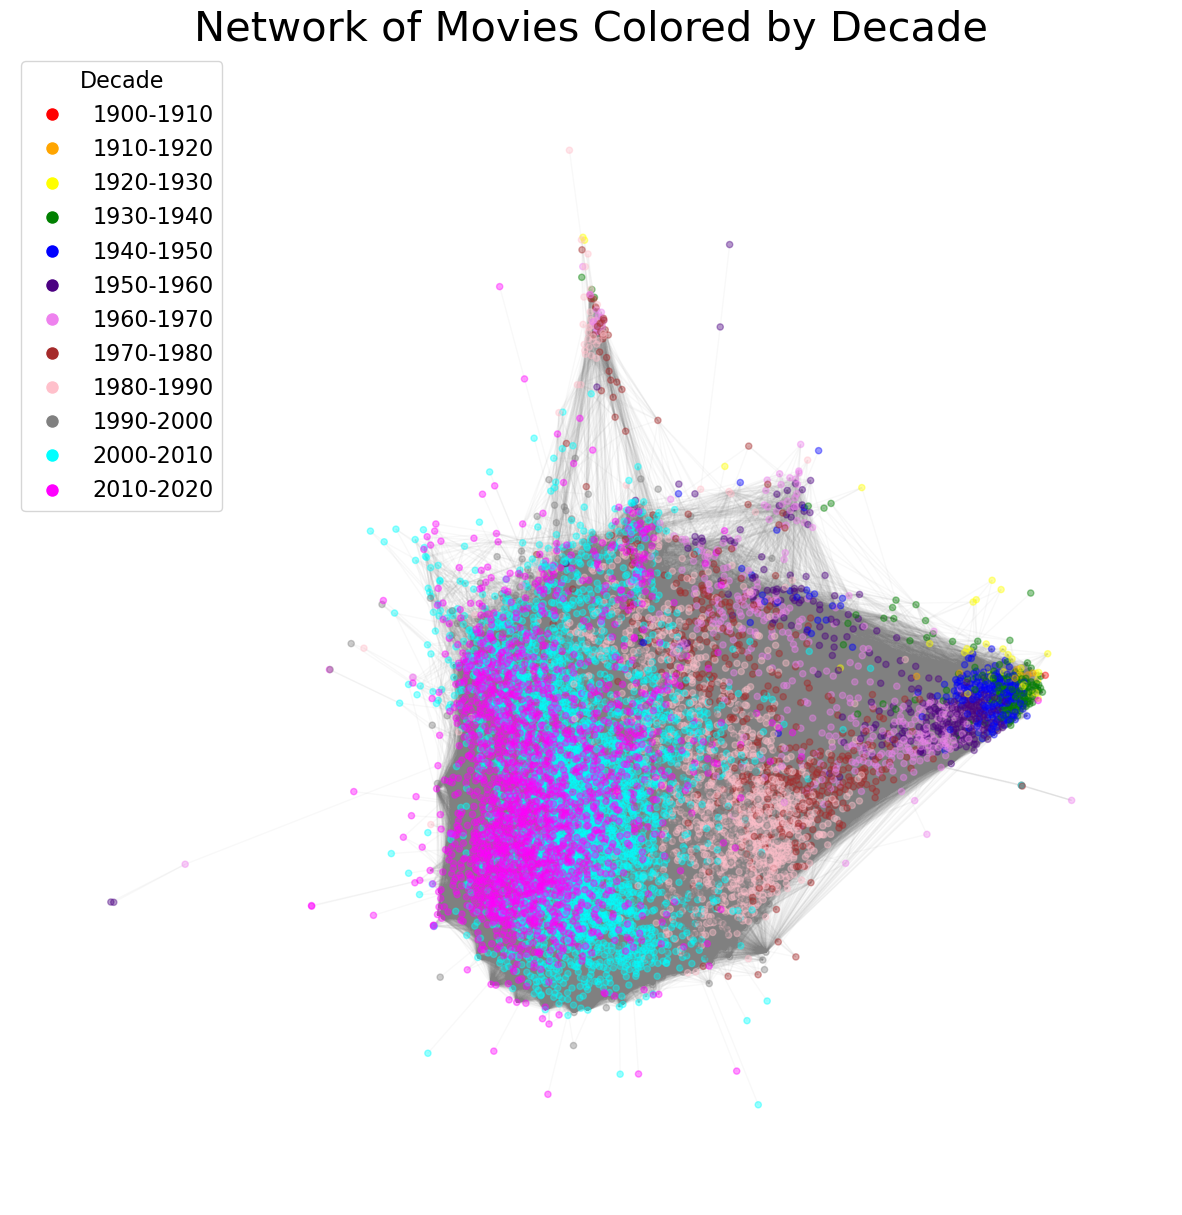

In [70]:
# Define a color map for the decades
decade_colors = {
    (1900, 1910): 'red',
    (1910, 1920): 'orange',
    (1920, 1930): 'yellow',
    (1930, 1940): 'green',
    (1940, 1950): 'blue',
    (1950, 1960): 'indigo',
    (1960, 1970): 'violet',
    (1970, 1980): 'brown',
    (1980, 1990): 'pink',
    (1990, 2000): 'gray',
    (2000, 2010): 'cyan',
    (2010, 2020): 'magenta'
}

# Create a list of colors for each node based on its decade community
node_colors = [decade_colors[decade] for node in G_Movies.nodes() for decade, nodes in decade_communities.items() if node in nodes]

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(G_Movies, positions, node_size=20, node_color=node_colors, alpha=0.4)
nx.draw_networkx_edges(G_Movies, positions, edge_color="grey", alpha=0.05)
# Create custom legend handles
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"{decade[0]}-{decade[1]}")
           for decade, color in decade_colors.items()]
plt.legend(title='Decade', loc='upper left', handles=handles, fontsize=16, title_fontsize=16)
plt.title("Network of Movies Colored by Decade", fontsize=30)
plt.axis('off')
plt.show()

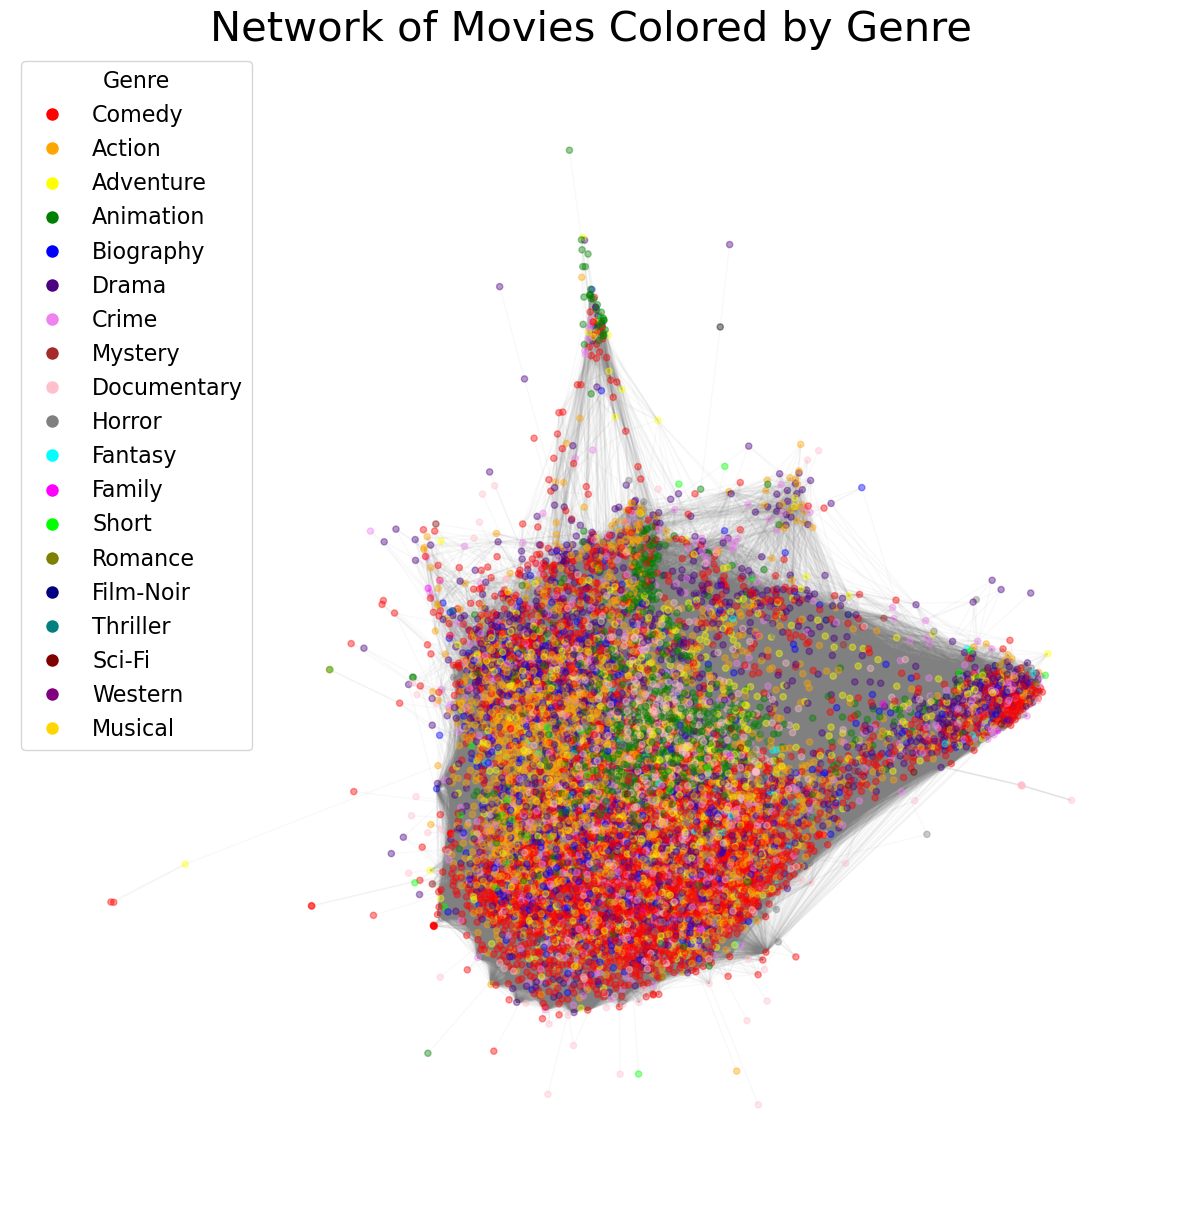

In [72]:
# Define a color map for the genres
genre_colors = {
    'Comedy': 'red',
    'Action': 'orange',
    'Adventure': 'yellow',
    'Animation': 'green',
    'Biography': 'blue',
    'Drama': 'indigo',
    'Crime': 'violet',
    'Mystery': 'brown',
    'Documentary': 'pink',
    'Horror': 'gray',
    'Fantasy': 'cyan',
    'Family': 'magenta',
    'Short': 'lime',
    'Romance': 'olive',
    'Film-Noir': 'navy',
    'Thriller': 'teal',
    'Sci-Fi': 'maroon',
    'Western': 'purple',
    'Musical': 'gold'
}

# Create a list of colors for each node based on its genre community
node_colors = []
default_color = 'black'  # Define a default color for nodes without a genre

for node in G_Movies.nodes():
    node_color = default_color  # Default color if no genre is found
    for genre, nodes in genre_communities.items():
        if node in nodes:
            node_color = genre_colors[genre]
            break
    node_colors.append(node_color)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(G_Movies, positions, node_size=20, node_color=node_colors, alpha=0.4)
nx.draw_networkx_edges(G_Movies, positions, edge_color="grey", alpha=0.05)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=genre)
           for genre, color in genre_colors.items()]
plt.legend(title='Genre', loc='upper left', handles=handles, fontsize=16, title_fontsize=16)
plt.title('Network of Movies Colored by Genre', fontsize=30)
plt.axis('off')
plt.show()

As we see from the plots the communities made from genre are not very clear, this was also expected from looking at the modularity of the network whereas it is much easier to see the division in the decade communities, which fits with the modularity of the decade communities being considerably higher.